In [1]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
import functions_fatiando as ft
from timeit import default_timer as time
from matplotlib import pyplot as plt
%matplotlib inline

## Create the model

In [2]:
# Polygonal Prism model
verts1 = [[-3500, -3000], [-2000, -3000], [-2000, 3000], [-3500, 3000]]
#verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'density':550})]

R1 = 1000 #Radius 1
R2 = 750 #Radius 2
xc1, yc1, zc1 = 3000., -2000., 2000. #Center of sphere 1
xc2, yc2, zc2 = 1000., 2500., 1800. #Center of sphere 2
model_sphere = [ft.mesher_Sphere(xc1, yc1, zc1 ,R1, props={'density':600}),
                ft.mesher_Sphere(xc2, yc2, zc2, R2, props={'density': -500})]

## Grid and Forward model

In [3]:
# Create a regular grid at 0m height
shape = (50, 50)
N = shape[0]*shape[1]
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = ft.gridder_regular(area, shape, z=-100.)
xi_plot = xi/1000
yi_plot = yi/1000
#print (area[1]-area[0])/(shape[0]-1.)

In [4]:
# Vertical component of the gravitational atraction observed
data = []
delta_g = []
dobs_prism = ft.polyprism_gz(xi, yi, zi, model_prism)
dobs_sphere = ft.sphere_gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

## True data plot noise free

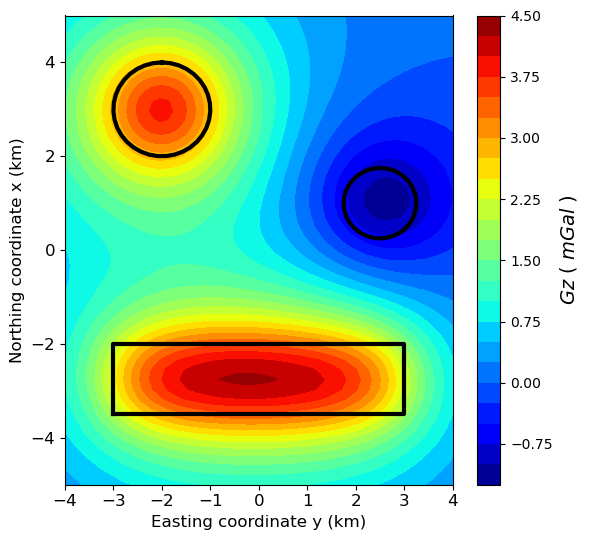

In [5]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

#x_p2 = [-3, -2.5, 3.5, 3, -3.]
#y_p2 = [4, 4.5, 0, -0.5, 4]

# plot of the vertical component of the gravitational atraction at z=0 
fig=plt.figure(figsize=(6,5.5))
fig.patch.set_facecolor('xkcd:white')
plt.plot()
plt.tricontourf(yi_plot,xi_plot,data[0],22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (km)', fontsize=12)
#mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout();
#plt.savefig('figures/synthetic_data.png', dpi=300)

## Equivalent Layer Depth

In [6]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Classical Equivalent layer

In [7]:
p_list = []
delta_p_classical = []
A = fc.sensibility_matrix(xi,yi,zi,zj,N)
I = np.identity(N)
ATA = A.T.dot(A)
mu = (np.trace(ATA)/N)*10**(-2)
AI = np.linalg.inv(ATA+mu*I)
p_0 = (AI.dot(A.T)).dot(data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p = (AI.dot(A.T)).dot(data[i+1])
    p_list.append(p)
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical.append(norm_pl)
gz_c = np.dot(A,p)

## Fast Eq. Layer BCCB

In [8]:
# Predicted data
rho_c_list = []
delta_p_BCCB = []
itmax = 40
rho_c_0, gz_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[0],itmax)
norm_rho_c_0 = np.linalg.norm(rho_c_0)
for i in range(len(data)-1):
    rho_c, gz_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[i+1],itmax)
    rho_c_list.append(rho_c)
    norm_rho_c = np.linalg.norm(rho_c-rho_c_0)/norm_rho_c_0
    delta_p_BCCB.append(norm_rho_c)

## Deconvolution

In [9]:
rho_c_dec_list = []
delta_p_dec = []
rho_c_0_dec, gz_dec = fc.fast_eq_dec(xi,yi,zi,zj,shape,data[0])
rho_c_dec_list.append(rho_c_0_dec)
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for i in range(len(data)-1):
    rho_c_dec, gz_dec = fc.fast_eq_dec(xi,yi,zi,zj,shape,data[i+1])
    rho_c_dec_list.append(rho_c_dec)
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution with Wiener stabilization

In [10]:
# Regularization factor of Wiener deconvolution
a, b, c = -15, -20, -25
mu0 = 10**(a)
mu1 = 10**(b)
mu2 = 10**(c)

delta_p_dec_wiener0 = []
delta_p_dec_wiener1 = []
delta_p_dec_wiener2 = []
rho_c_dec_wiener_list0 = []
rho_c_dec_wiener_list1 = []
rho_c_dec_wiener_list2 = []

rho_c_0_dec_wiener, gz_dec_0_wiener = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[0],mu0)
rho_c_dec_wiener_list0.append(rho_c_0_dec_wiener)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)

rho_c_1_dec_wiener, gz_dec_1_wiener = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[0],mu1)
rho_c_dec_wiener_list1.append(rho_c_1_dec_wiener)
norm_rho_c_1_dec_wiener = np.linalg.norm(rho_c_1_dec_wiener)

rho_c_2_dec_wiener, gz_dec_2_wiener = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[0],mu2)
rho_c_dec_wiener_list2.append(rho_c_2_dec_wiener)
norm_rho_c_2_dec_wiener = np.linalg.norm(rho_c_2_dec_wiener)

for j in range(len(data)-1):
    
    rho_c_dec_wiener0, gz_dec_wiener0 = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[j+1],mu0)
    rho_c_dec_wiener_list0.append(rho_c_dec_wiener0)
    norm_rho_c_dec_wiener0 = np.linalg.norm(rho_c_dec_wiener0 - rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    delta_p_dec_wiener0.append(norm_rho_c_dec_wiener0)
    
    rho_c_dec_wiener1, gz_dec_wiener1 = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[j+1],mu1)
    rho_c_dec_wiener_list1.append(rho_c_dec_wiener1)
    norm_rho_c_dec_wiener1 = np.linalg.norm(rho_c_dec_wiener1-rho_c_1_dec_wiener)/norm_rho_c_1_dec_wiener
    delta_p_dec_wiener1.append(norm_rho_c_dec_wiener1)
    
    rho_c_dec_wiener2, gz_dec_wiener2 = fc.fast_eq_dec_wiener(xi,yi,zi,zj,shape,data[j+1],mu2)
    rho_c_dec_wiener_list2.append(rho_c_dec_wiener2)
    norm_rho_c_dec_wiener2 = np.linalg.norm(rho_c_dec_wiener2-rho_c_2_dec_wiener)/norm_rho_c_2_dec_wiener
    delta_p_dec_wiener2.append(norm_rho_c_dec_wiener2)

## Figure plots

## Transformations comparison - Upward continuation

In [11]:
z_up = np.ones_like(xi) * -500

dobs_prism_up = ft.polyprism_gz(xi, yi, z_up, model_prism)
dobs_sphere_up = ft.sphere_gz(xi, yi, z_up, model_sphere)
dobs_up = dobs_sphere_up + dobs_prism_up

In [12]:
A_up = fc.sensibility_matrix(xi,yi,z_up,zj,N)

gz_c_up = np.dot(A_up,p_list[-1])
gz_bccb_up = np.dot(A_up,rho_c_list[-1])
gz_dec_up = np.dot(A_up,rho_c_dec_list[-1])
gz_dec_wiener0_up = np.dot(A_up,rho_c_dec_wiener_list0[-1])
gz_dec_wiener1_up = np.dot(A_up,rho_c_dec_wiener_list1[-1])
gz_dec_wiener2_up = np.dot(A_up,rho_c_dec_wiener_list2[-1])

In [13]:
scale_max = np.max(gz_c_up)
scale_min = np.min(gz_c_up)

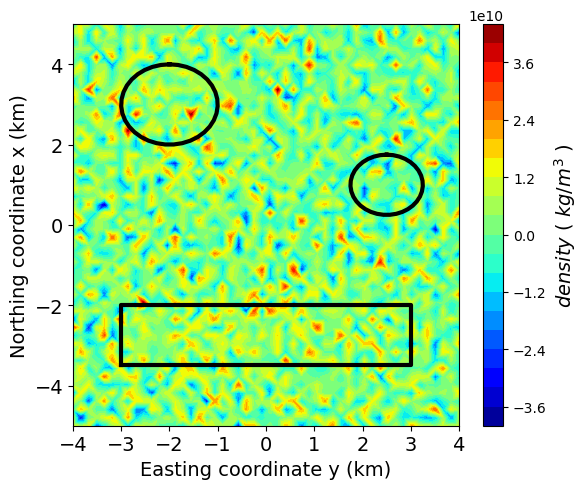

In [14]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,rho_c,22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg/m^{3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

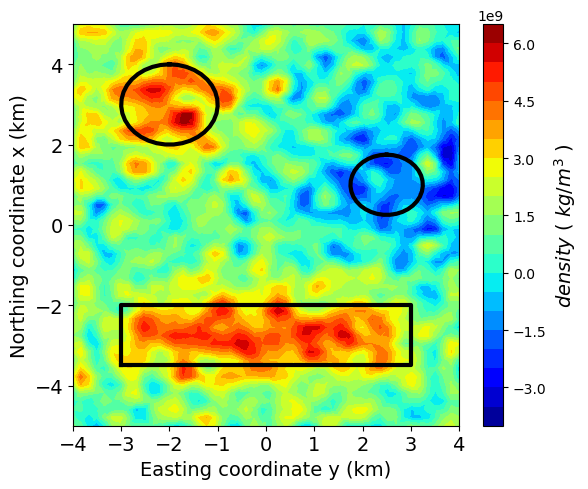

In [15]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,rho_c_dec_wiener1, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$density$ ( $kg/m^{3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

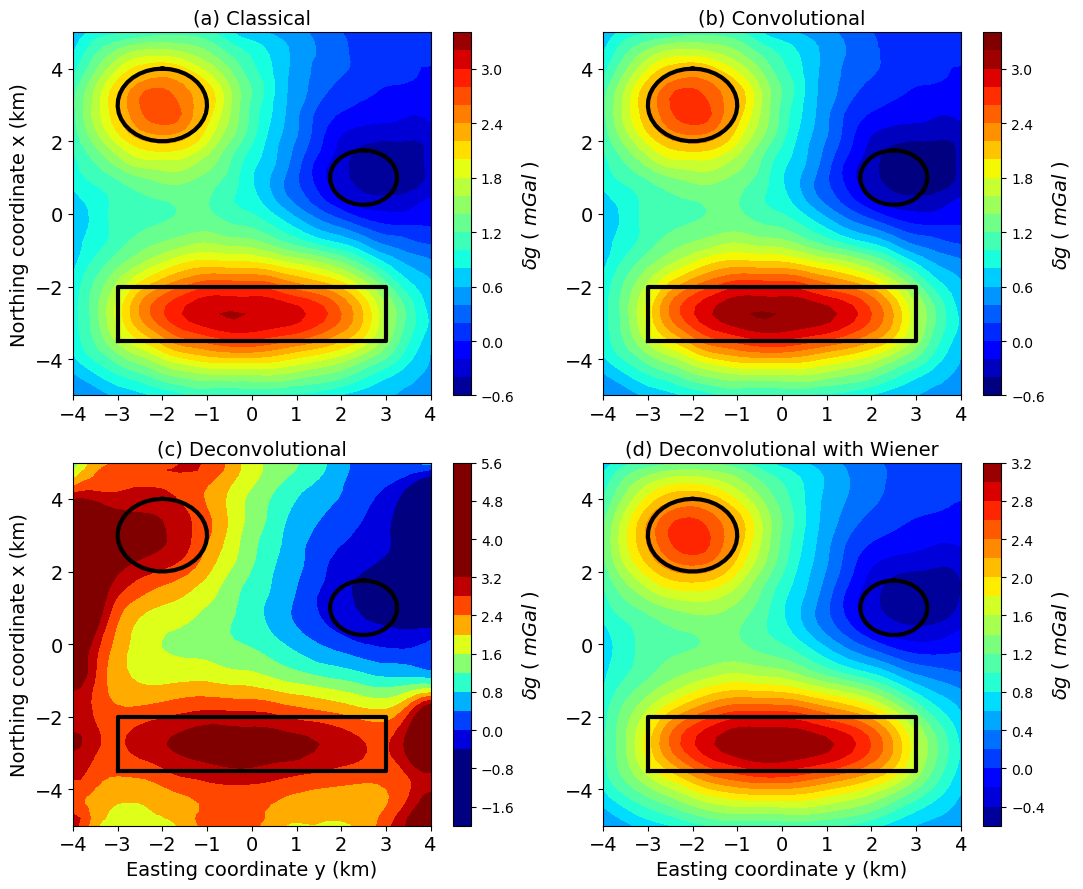

In [16]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a) Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_c_up,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b) Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_bccb_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c) Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d) Deconvolutional with Wiener', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener1_up,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/stability_grav_comparison.png', dpi=300)

In [17]:
print (np.mean(np.abs(dobs_up-gz_c_up)), ('(Classical method)'))
print (np.mean(np.abs(dobs_up-gz_bccb_up)), ('(CG BTTB method)'))
print (np.mean(np.abs(dobs_up-gz_dec_up)), ('(Deconvolutional method)'))
print (np.mean(np.abs(dobs_up-gz_dec_wiener0_up)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(dobs_up-gz_dec_wiener1_up)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(dobs_up-gz_dec_wiener2_up)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(dobs_up-gz_c_up)), ('(Classical method)'))
print (np.std(np.abs(dobs_up-gz_bccb_up)), ('(CG BTTB method)'))
print (np.std(np.abs(dobs_up-gz_dec_up)), ('(Deconvolutional method)'))
print (np.std(np.abs(dobs_up-gz_dec_wiener0_up)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(dobs_up-gz_dec_wiener1_up)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(dobs_up-gz_dec_wiener2_up)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

0.03675915853871514 (Classical method)
0.03666871374940971 (CG BTTB method)
0.714410832826841 (Deconvolutional method)
1.2786905676186233 (Deconvolutional w\ Wiener overshoot μ method)
0.02937772471406306 (Deconvolutional w\ Wiener optimal μ method)
0.7004459488124946 (Deconvolutional w\ Wiener suboptimal μ method)

0.032190106264673536 (Classical method)
0.03237288286922276 (CG BTTB method)
0.7688828123495896 (Deconvolutional method)
0.8249004849753158 (Deconvolutional w\ Wiener overshoot μ method)
0.023506744401557103 (Deconvolutional w\ Wiener optimal μ method)
0.7503461199909391 (Deconvolutional w\ Wiener suboptimal μ method)


## Transformations comparison - From Gz to Gxx

In [18]:
dobs_prism_xx = ft.polyprism_gxx(xi, yi, zi, model_prism)
dobs_sphere_xx = ft.sphere_gxx(xi, yi, zi, model_sphere)
dobs_xx = dobs_sphere_xx + dobs_prism_xx

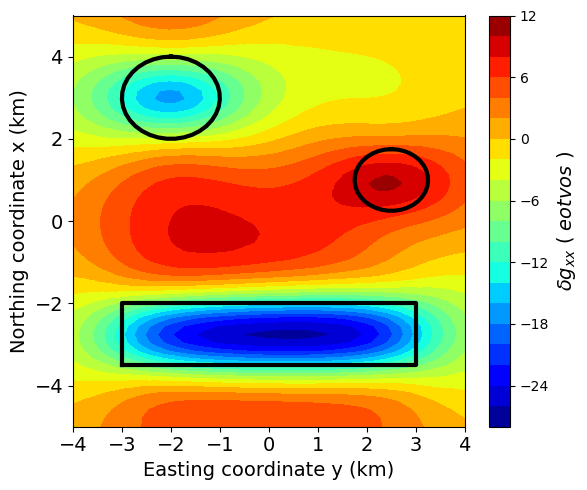

In [19]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,dobs_xx, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

In [20]:
A_gxx = fc.classic_grav_tensor_xx(xi,yi,zi,zj,N)

gz_c_xx = np.dot(A_gxx,p_list[-1])
gz_bccb_xx = np.dot(A_gxx,rho_c_list[-1])
gz_dec_xx = np.dot(A_gxx,rho_c_dec_list[-1])
gz_dec_wiener0_xx = np.dot(A_gxx,rho_c_dec_wiener_list0[-1])
gz_dec_wiener1_xx = np.dot(A_gxx,rho_c_dec_wiener_list1[-1])
gz_dec_wiener2_xx = np.dot(A_gxx,rho_c_dec_wiener_list2[-1])

In [21]:
scale_max = np.max(gz_c_xx)
scale_min = np.min(gz_c_xx)

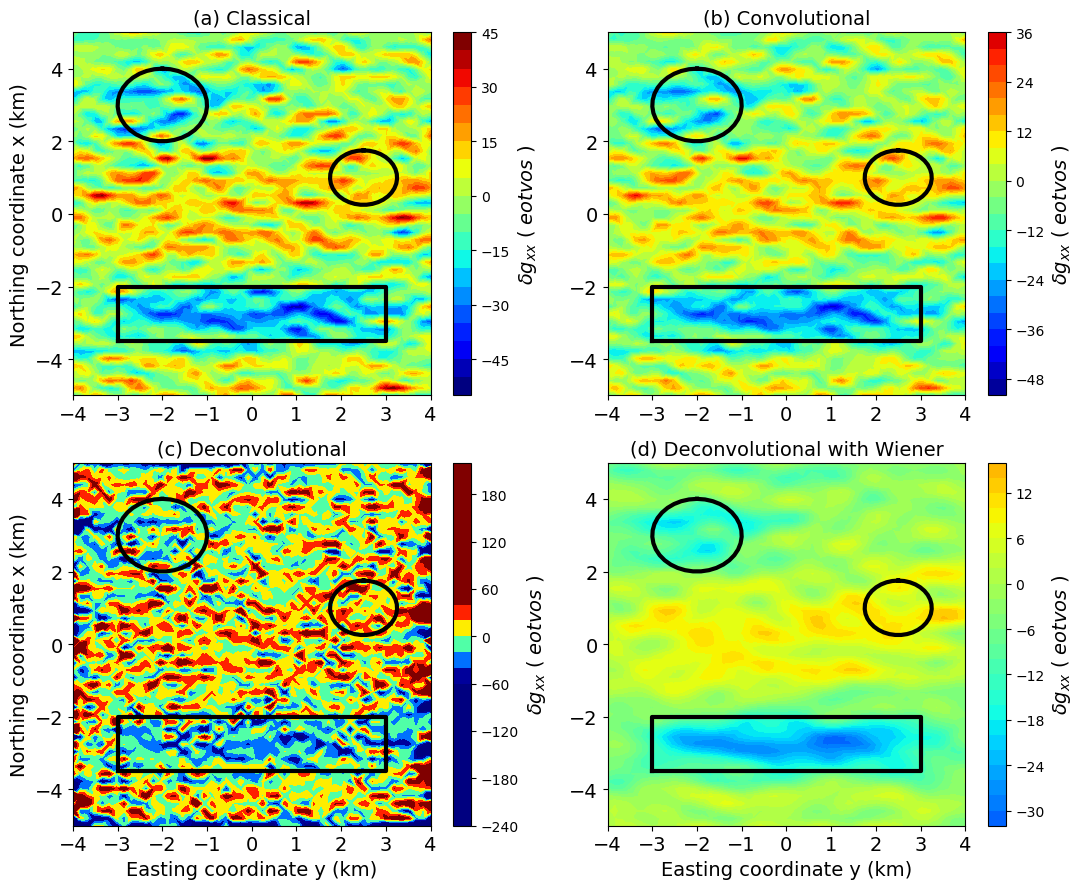

In [22]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a) Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_c_xx,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b) Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_bccb_xx,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c) Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_xx,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d) Deconvolutional with Wiener', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener1_xx,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/stability_grav_comparison.png', dpi=300)

In [23]:
print (np.mean(np.abs(dobs_xx-gz_c_xx)), ('(Classical method)'))
print (np.mean(np.abs(dobs_xx-gz_bccb_xx)), ('(CG BTTB method)'))
print (np.mean(np.abs(dobs_xx-gz_dec_xx)), ('(Deconvolutional method)'))
print (np.mean(np.abs(dobs_xx-gz_dec_wiener0_xx)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(dobs_xx-gz_dec_wiener1_xx)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(dobs_xx-gz_dec_wiener2_xx)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(dobs_xx-gz_c_xx)), ('(Classical method)'))
print (np.std(np.abs(dobs_xx-gz_bccb_xx)), ('(CG BTTB method)'))
print (np.std(np.abs(dobs_xx-gz_dec_xx)), ('(Deconvolutional method)'))
print (np.std(np.abs(dobs_xx-gz_dec_wiener0_xx)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(dobs_xx-gz_dec_wiener1_xx)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(dobs_xx-gz_dec_wiener2_xx)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

9.488071161779086 (Classical method)
7.45386966426484 (CG BTTB method)
29.274895240388428 (Deconvolutional method)
6.084229138325827 (Deconvolutional w\ Wiener overshoot μ method)
2.9360677330127483 (Deconvolutional w\ Wiener optimal μ method)
27.450175887905626 (Deconvolutional w\ Wiener suboptimal μ method)

6.972223756279755 (Classical method)
5.400872308413702 (CG BTTB method)
26.706226741781308 (Deconvolutional method)
5.7378713073943315 (Deconvolutional w\ Wiener overshoot μ method)
2.3727930099673213 (Deconvolutional w\ Wiener optimal μ method)
24.503707060076987 (Deconvolutional w\ Wiener suboptimal μ method)


## Transformations comparison - From Gz to Gzz

In [24]:
dobs_prism_zz = ft.polyprism_gzz(xi, yi, zi, model_prism)
dobs_sphere_zz = ft.sphere_gzz(xi, yi, zi, model_sphere)
dobs_zz = dobs_sphere_zz + dobs_prism_zz

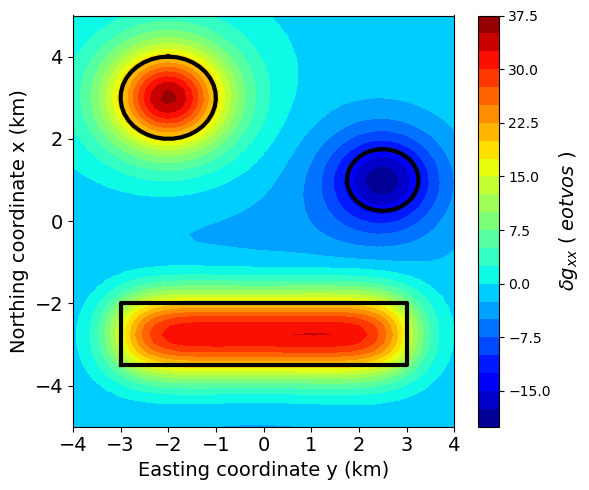

In [25]:
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,dobs_zz, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_grav_0.png', dpi=300)

In [26]:
A_gzz = fc.classic_grav_tensor_zz(xi,yi,zi,zj,N)

gz_c_zz = np.dot(A_gzz,p_list[-1])
gz_bccb_zz = np.dot(A_gzz,rho_c_list[-1])
gz_dec_zz = np.dot(A_gzz,rho_c_dec_list[-1])
gz_dec_wiener0_zz = np.dot(A_gzz,rho_c_dec_wiener_list0[-1])
gz_dec_wiener1_zz = np.dot(A_gzz,rho_c_dec_wiener_list1[-1])
gz_dec_wiener2_zz = np.dot(A_gzz,rho_c_dec_wiener_list2[-1])

In [27]:
scale_max = np.max(gz_c_zz)
scale_min = np.min(gz_c_zz)

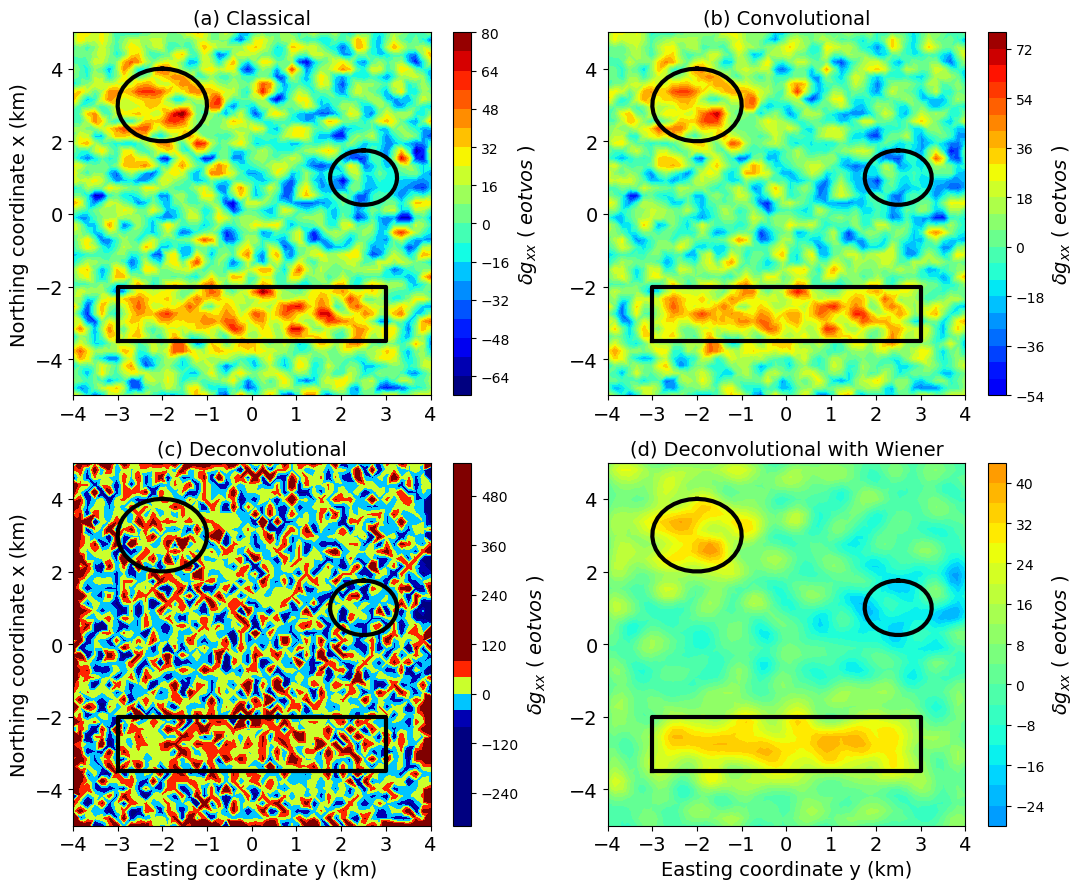

In [28]:
# Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a) Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_c_zz,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b) Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_bccb_zz,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c) Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_zz,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d) Deconvolutional with Wiener', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,gz_dec_wiener1_zz,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g_{xx}$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/stability_grav_comparison.png', dpi=300)

In [29]:
print (np.mean(np.abs(dobs_zz-gz_c_zz)), ('(Classical method)'))
print (np.mean(np.abs(dobs_zz-gz_bccb_zz)), ('(CG BTTB method)'))
print (np.mean(np.abs(dobs_zz-gz_dec_zz)), ('(Deconvolutional method)'))
print (np.mean(np.abs(dobs_zz-gz_dec_wiener0_zz)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(dobs_zz-gz_dec_wiener1_zz)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(dobs_zz-gz_dec_wiener2_zz)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(dobs_zz-gz_c_zz)), ('(Classical method)'))
print (np.std(np.abs(dobs_zz-gz_bccb_zz)), ('(CG BTTB method)'))
print (np.std(np.abs(dobs_zz-gz_dec_zz)), ('(Deconvolutional method)'))
print (np.std(np.abs(dobs_zz-gz_dec_wiener0_zz)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(dobs_zz-gz_dec_wiener1_zz)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(dobs_zz-gz_dec_wiener2_zz)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

15.147342513596744 (Classical method)
11.952576834146475 (CG BTTB method)
57.5679193114218 (Deconvolutional method)
7.619128821250539 (Deconvolutional w\ Wiener overshoot μ method)
4.817298945637235 (Deconvolutional w\ Wiener optimal μ method)
52.429078405366795 (Deconvolutional w\ Wiener suboptimal μ method)

11.455845511391798 (Classical method)
9.064367342718047 (CG BTTB method)
52.824054411861326 (Deconvolutional method)
8.805124658755874 (Deconvolutional w\ Wiener overshoot μ method)
3.7395792539013817 (Deconvolutional w\ Wiener optimal μ method)
48.70812952325447 (Deconvolutional w\ Wiener suboptimal μ method)
